In [1]:
import numpy as np

In [2]:
#body_xyz_data = np.load('./recording_19_56_30_gmt-4/output_data/mediapipe_body_3d_xyz.npy')
#left_hand_xyz_data = np.load('./recording_19_56_30_gmt-4/output_data/mediapipe_left_hand_3d_xyz.npy')
#right_hand_xyz_data = np.load('./recording_19_56_30_gmt-4/output_data/mediapipe_right_hand_3d_xyz.npy')

In [3]:
# get max distance between left and right hand. this will be the approximated wingspan.

# get difference between max left and max right when left is farthest left and right is farthest right. the one with the greatest distance wins
#left_max = np.max(left_hand_xyz_data[:, :, 0])  # min since 0,0 starts at top-left
#left_max_index = np.where(left_hand_xyz_data == left_max)
#left_max_wingspan = left_hand_xyz_data[left_max_index[0], left_max_index[1], 2][0] - left_max
#print(left_max_wingspan)
#right_max = np.max(right_hand_xyz_data[:, :, 2])  # min since 0,0 starts at top-right
#right_max_index = np.where(right_hand_xyz_data == right_max)
#right_max_wingspan = right_hand_xyz_data[right_max_index[0], right_max_index[1], 0][0] - right_max
#print(right_max_wingspan)

### Taken from example .ipynb

In [4]:
from pathlib import Path

try:
    import numpy as np
except Exception as e:
    print(e)
    %pip install numpy
    import numpy as np


try:
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
except Exception as e:
    print(e)
    %pip install plotly
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    

In [5]:
# function to get data for particular body part
def get_bodypart_data(bodypart = "left_index"):
    path_to_recording = "C:\\Users\\briid\\Documents\\Research\\Arm-Simulation-with-Forces\\experimentation\\freemocap\\recording_19_56_30_gmt-4"
    mediapipe_indices = ['nose',
    'left_eye_inner',
    'left_eye',
    'left_eye_outer',
    'right_eye_inner',
    'right_eye',
    'right_eye_outer',
    'left_ear',
    'right_ear',
    'mouth_left',
    'mouth_right',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_pinky',
    'right_pinky',
    'left_index',
    'right_index',
    'left_thumb',
    'right_thumb',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle',
    'left_heel',
    'right_heel',
    'left_foot_index',
    'right_foot_index']

    joint_to_plot_index = mediapipe_indices.index(bodypart)


    path_to_recording = Path(path_to_recording)
    path_to_center_of_mass_npy = path_to_recording/'output_data'/'center_of_mass'/'total_body_center_of_mass_xyz.npy'
    path_to_freemocap_3d_body_data_npy = path_to_recording/'output_data'/'mediapipe_body_3d_xyz.npy'

    freemocap_3d_body_data = np.load(path_to_freemocap_3d_body_data_npy)
    total_body_com_data = np.load(path_to_center_of_mass_npy)

    return freemocap_3d_body_data[:,joint_to_plot_index,:]

#### Experimenting:

In [6]:
# get data for both hands
left_hand_data = get_bodypart_data("left_wrist")
right_hand_data = get_bodypart_data("right_wrist")
# and index fingers
left_index_data = get_bodypart_data("left_index")
right_index_data = get_bodypart_data("right_index")

In [7]:
# function to get distance between two body parts
# parameters are the data arrays for the body parts
# returns array of distances between parts
def dist_between_vertices(first_part, second_part):
    cur_dist = np.ndarray(shape = first_part.shape, dtype = first_part.dtype)
    for i in range(0, len(first_part) - 1):     # get the distance for each frame of the video (excluding last frame)
        cur_dist[i] = np.linalg.norm(first_part[i] - second_part[i])
        #print(cur_dist[i])]
    return cur_dist[:-1, 0]

In [8]:
dist = dist_between_vertices(left_index_data, right_index_data)

In [9]:
# find largest distance between both hands
np.max(dist)

921.5067001657222

In [10]:
# get ratio to real distance in meters
real_height_metric = 1.78     # meters
sim_wingspan = np.max(dist)     # max distance between wrists via `freemocap`

sim_to_real_conversion_factor = real_height_metric / sim_wingspan
print(sim_to_real_conversion_factor)

0.0019316191620526338


In this case, we have acquired a sim-to-real (metric) conversion factor of approximately `0.0018990637829`.

For a roughly approximate method of checking the validity of the conversion factor, we will calculate the distance from the eyes (`left_eye` and `right_eye`) to the heels (`left_heel` and `right_heel`).

***Keep in mind, the full body was not in frame for this run at any point, so this estimate is going to be off by a decent margin. This was done for experimentation purposes only.***

In [11]:
# get data for eyes and heels
left_eye_data = get_bodypart_data("left_eye")
right_eye_data = get_bodypart_data("right_eye")
left_heel_data = get_bodypart_data("left_heel")
right_heel_data = get_bodypart_data("right_heel")

In [12]:
# calculate distance for each side, then divide by 2 to get the average of the two
height_approx_left = np.max(dist_between_vertices(left_eye_data, left_heel_data))
height_approx_right = np.max(dist_between_vertices(right_eye_data, right_heel_data))
rough_approx_height_sim = (height_approx_left + height_approx_right) / 2

In [13]:
rough_approx_height = rough_approx_height_sim * sim_to_real_conversion_factor
print("%s meters" % rough_approx_height)

2.379298277951489 meters


Not great, but only a little less than 25% off from the real value, so not too terrible. Let's try something more reasonable, like the length of one arm.

In [14]:
left_shoulder_data = get_bodypart_data("left_shoulder")
right_shoulder_data = get_bodypart_data("right_shoulder")
np.max(left_shoulder_data)

803.6215345400643

In [15]:
# right hand to shoulder
print("%s meters" % (np.max(dist_between_vertices(right_shoulder_data, right_index_data)) * sim_to_real_conversion_factor))

0.9283948802129095 meters


In [16]:
# left hand to shoulder
print("%s meters" % (np.max(dist_between_vertices(left_index_data, left_shoulder_data)) * sim_to_real_conversion_factor))

0.8022724104020942 meters


### Trying to do depth:

- try to do this by calculating the ratio between the current length of any given body part and its longest length.
    - the shorter a part is as compared to its longest length, the more depth needs to be accounted for. 
    - a distance of 0 between the start and end of a body part segment would mean it is directly in line with the camera. a distance of length N where N is the median of the 5 longest measurements of length between two points (i.e. elbow and wrist), should show that the segment is normal to the angle of the camera (thus no depth).
- to figure out which way the depth goes (forwards or back), calculate the difference in light intensity between the vertices in question. whichever one is brighter is closer.
    - could also see whether it's getting brighter or darker over time, which should probably help, I think

In [17]:
# taken from the default output .ipynb
bodypart = 'left_index'
path_to_recording = "C:\\Users\\briid\\Documents\\Research\\Arm-Simulation-with-Forces\\experimentation\\freemocap\\recording_19_56_30_gmt-4"
mediapipe_indices = ['nose',
'left_eye_inner',
'left_eye',
'left_eye_outer',
'right_eye_inner',
'right_eye',
'right_eye_outer',
'left_ear',
'right_ear',
'mouth_left',
'mouth_right',
'left_shoulder',
'right_shoulder',
'left_elbow',
'right_elbow',
'left_wrist',
'right_wrist',
'left_pinky',
'right_pinky',
'left_index',
'right_index',
'left_thumb',
'right_thumb',
'left_hip',
'right_hip',
'left_knee',
'right_knee',
'left_ankle',
'right_ankle',
'left_heel',
'right_heel',
'left_foot_index',
'right_foot_index']

joint_to_plot_index = mediapipe_indices.index(bodypart)


path_to_recording = Path(path_to_recording)
path_to_center_of_mass_npy = path_to_recording/'output_data'/'center_of_mass'/'total_body_center_of_mass_xyz.npy'
path_to_freemocap_3d_body_data_npy = path_to_recording/'output_data'/'mediapipe_body_3d_xyz.npy'

freemocap_3d_body_data = np.load(path_to_freemocap_3d_body_data_npy)
total_body_com_data = np.load(path_to_center_of_mass_npy)

# save pre-modification for testing purposes
body_data_pre_mod = freemocap_3d_body_data

In [18]:
# get indices for body parts
def get_index(body_part = 'left_wrist'):
    return mediapipe_indices.index(body_part)

In [19]:
# function to get data for particular body part
def get_bodypart_data(bodypart = "left_index"):
    
    joint_to_plot_index = mediapipe_indices.index(bodypart)

    return freemocap_3d_body_data[:,joint_to_plot_index,:]

In [20]:
# function to get distance between two body parts
# parameters are the data arrays for the body parts
# returns array of distances between parts
def dist_between_vertices(first_part, second_part):
    cur_dist = np.ndarray(shape = first_part.shape, dtype = first_part.dtype)
    for i in range(0, len(first_part) - 1):     # get the distance for each frame of the video (excluding last frame)
        cur_dist[i] = np.linalg.norm(first_part[i] - second_part[i])
        #print(cur_dist[i])]
    return cur_dist[:-1, 0]

In [21]:
# get body part data
left_index_data = get_bodypart_data("left_index")
left_elbow_data = get_bodypart_data("left_elbow")

In [22]:
# ratio between current length and zero length:
left_hand_to_elbow_array = dist_between_vertices(left_index_data, left_elbow_data)

In [23]:
# get median of largest distances between vertices/bodyparts
def max_dist_between_parts(dist_array):
    ind = (np.argpartition(dist_array, -20)[-20:-5])
    return np.median(dist_array[ind])

In [24]:
# get approximate distance between vertices/body parts
left_hand_to_elbow_dist = max_dist_between_parts(left_hand_to_elbow_array)
print(left_hand_to_elbow_dist)

290.24718732016095


In [25]:
# calculate the angle of the segment (body part) from the normal (where it is longest)
def angle_from_normal(cur_dist, max_dist):
    return np.arccos(cur_dist / max_dist)

In [26]:
angle_from_normal(0, left_hand_to_elbow_dist)

1.5707963267948966

Nice! The output, `1.570796`, is half of pi, or pi/2. This is exactly what we were looking for when the cur_dist is 0, telling us that it works as expected.

Now, use this to calculate the distance the (body part) vertex is away from the norm with the angle, and there's your depth.

In [27]:
test_vertex_one = get_bodypart_data('left_index')
test_vertex_two = get_bodypart_data('left_elbow')
test_dist_array = dist_between_vertices(test_vertex_one, test_vertex_two)

test_dist_array = test_dist_array
test_max_dist = max_dist_between_parts(test_dist_array)
test_angle = angle_from_normal(test_dist_array[13], test_max_dist)
test_depth = np.sin(test_angle) * test_max_dist
print(test_angle)
print(test_depth)

0.6537383962511865
176.5162205135117


In [28]:
# get depth
#def get_depth(vertex_one, vertex_two, timestep):
#    dist_array = dist_between_vertices(vertex_one, vertex_two)
#    max_dist = max_dist_between_parts(dist_array)
#    cur_dist = dist_array[timestep]
#    angle = angle_from_normal(cur_dist, max_dist)
#    depth = np.sin(angle) * max_dist
#    return depth

In [29]:
# get depth
def get_depth(vertex_one, vertex_two):
    dist_array = dist_between_vertices(vertex_one, vertex_two)
    max_dist = max_dist_between_parts(dist_array)
    depths = list()
    for frame in dist_array:
        angle = angle_from_normal(frame, max_dist)
        depths.append(np.sin(angle) * max_dist)
    return depths

In [30]:
np.nan_to_num(get_depth(get_bodypart_data('left_index'), get_bodypart_data('left_elbow')))#, 10))

C:\Users\briid\AppData\Local\Temp\ipykernel_11856\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


array([116.75122891, 194.74853652, 218.094571  , 212.42779996,
       190.81636391, 169.0014874 , 171.72710234, 201.44669143,
       225.07495187, 226.75775192, 211.32724077, 198.13707719,
       193.61861749, 176.51622051, 150.38550301, 187.94464257,
       260.93218394, 286.75375456, 278.93111227, 237.34187661,
       195.32551475, 200.24234033, 207.60022024, 198.37928208,
       188.50974132, 191.07314759, 201.16519911, 208.95029309,
       209.74648145, 203.16991801, 192.32739358, 182.26491207,
       174.38221407, 166.66009221, 159.3676398 , 156.06443973,
       158.98607083, 166.18193291, 173.6161798 , 178.10319485,
       179.45698288, 180.54367431, 183.50246138, 186.91790376,
       188.83167496, 189.63797843, 190.4532368 , 191.3389638 ,
       192.36900841, 194.14046876, 196.26373997, 197.99262289,
       200.86659563, 207.1629386 , 215.91256847, 223.98251914,
       229.59888527, 232.24781549, 231.04431302, 225.77071018,
       219.21778046, 215.76344381, 216.10979943, 216.96

Test it out by running it for each time step then setting the values for `y` in the data output matrices to the calculated values with `get_depth`. 

Visualize in the same way it does by default in order to check how well it works.

In [31]:
# do depth for each time set, set for each vertex according to its nearest neighbor

In [32]:
# put together pairs for each of the vertices
# the first one is the point which will be moved on the y-axis, the second one for calculations
#vertex_pairs = [    # this set only for upper body
#    ['left_shoulder', 'right_shoulder'],
#    ['left_elbow', 'left_shoulder'],
#    ['left_index', 'left_elbow'],
#    ['right_elbow', 'right_shoulder'],
#    ['right_index','right_elbow']
#]
vertex_order = [
    [
        'left_shoulder',
        'right_shoulder'
    ],
    [
        'left_shoulder',
        'left_elbow',
        'left_wrist',
    ],
    [
        'right_shoulder',
        'right_elbow',
        'right_wrist'
    ]
]

In [33]:
# get length of body parts by vertex pairs
#def get_y_axes(vertex_pairs = vertex_pairs):
#    lengths = list()
#    for vertex_pair in vertex_pairs:
#        lengths.append(np.nan_to_num(get_depth(get_bodypart_data(vertex_pair[0]), get_bodypart_data(vertex_pair[1]))))
#    return lengths

# get y axes by order of body parts
def get_y_axes(vertex_order = vertex_order):
    y = list()
    for vertices in vertex_order:
        group_y = list()
        num_vertices = len(vertices)
        for i, vertex in enumerate(vertices):
            if i < (num_vertices - 1):
                y_dist_between_vertices = np.nan_to_num(get_depth(get_bodypart_data(vertices[i]), get_bodypart_data(vertices[i + 1])))
                if i > 0:
                    vertex_y = group_y[i - 1] +  y_dist_between_vertices    # add y depth of anchor to current
                else:
                    vertex_y = y_dist_between_vertices
                group_y.append(vertex_y)
        y.append(group_y)
    return y



In [34]:
# test get_y_axes
#print(np.asarray(get_y_axes()).shape)
print(get_y_axes())


[[array([139.27169946, 135.64864404, 136.5619357 , 142.76817905,
       150.26016047, 154.75029636, 154.99446746, 153.10831762,
       152.98717817, 157.6030731 , 165.98637402, 173.16590424,
       175.20199233, 172.95236739, 170.2543071 , 168.76337097,
       166.34993952, 161.53291958, 156.46929883, 153.94115722,
       153.24456952, 151.53315211, 147.19588532, 140.68080652,
       134.77772085, 133.82853419, 138.50300536, 143.54838468,
       144.38160861, 141.68203998, 138.79962317, 138.034828  ,
       141.04234678, 148.65858371, 157.92914313, 163.85102501,
       164.77884803, 163.82148868, 164.78358989, 168.37363301,
       174.0403687 , 182.27167054, 192.15183073, 200.09450232,
       203.58301571, 203.85942066, 203.9369248 , 204.65194307,
       204.15768458, 201.10054657, 196.43040607, 191.89042869,
       187.92373176, 184.35412369, 181.89988929, 181.05324597,
       181.018982  , 181.51083106, 183.3622761 , 186.200637  ,
       188.22623268, 188.97157656, 189.89115393, 191.

C:\Users\briid\AppData\Local\Temp\ipykernel_11856\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


In [35]:
# get y axes
y_axes = get_y_axes()
# account for difference between shoulder y-axes
y_axes[2] += y_axes[0]  # by adding it to the branch off the right shoulder

C:\Users\briid\AppData\Local\Temp\ipykernel_11856\1837775029.py:3: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cur_dist / max_dist)


In [36]:
# put together dictionary coordinating everything
depth_dict = {
    'vertex_order': vertex_order,                # pairs of body parts/segments
    'y_axes': y_axes,   # approximated depth
}

### Bringing it all together now:

- current setup uses left shoulder as temp anchor

In [37]:
freemocap_3d_body_data[20, :, 1]    # the '1' here indicates the y-axis

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
# get indices for body parts used
indices = list()
for vertices in depth_dict['vertex_order']:
    for vertex in vertices:
        indices.append(get_index(vertex))

print(indices)

[11, 12, 11, 13, 15, 12, 14, 16]


for all in dict:
    for all vertices:
        set y to y_axis_depth + y_axis_depth(vertex_anchor)     <--vertex_anchor referring to other vertex, i.e. left_shoulder for left_elbow

In [39]:
# approximate depth for the video recording
def set_depth(depth_dict = depth_dict, body_data = freemocap_3d_body_data):
    depth_body_data = body_data[:, :, 1]    # y axis of each part on each frame

    # go through and set y-axes values accordingly
    for i, order_group in enumerate(depth_dict['y_axes']):
        cur_length = len(depth_dict['vertex_order'][i])
        # go thru all vertices in current group
        for j, vertex in enumerate(order_group):
            if j < (cur_length - 1):
                # set y axis for each vertex in the order group
                cur_vertex = depth_dict['vertex_order'][i][j + 1]   # + 1 so that it applies to the non-anchor vertex
                vertex_index = mediapipe_indices.index(cur_vertex)
                body_data[:, vertex_index, 1] = np.append(vertex, 0)

    body_data[:, :, 1] = depth_body_data
    return body_data

In [40]:
# testing...
test_body_data = freemocap_3d_body_data

test_body_data = set_depth(body_data = test_body_data)

In [41]:
print(test_body_data[:, 13, 1])

[124.26946929   0.           0.          81.94696189 124.50855967
 134.83325257 134.30685294 136.79753594 143.09640201 146.67114592
 144.5399557  139.31463721 136.95320715 139.47598868 140.85449555
 133.95590564 115.58447435  96.65072273  97.10505061 106.11072833
 106.78885995 102.34387607 101.13054776 101.50233097  98.42010651
  91.91503743  84.53822665  78.90429664  77.87599206  81.21112961
  85.14742661  88.84015083  95.08060135 103.62696578 110.30812361
 112.48582492 111.32654706 110.44136938 112.20389326 115.74993185
 118.9427059  120.75264718 121.55866476 122.44116377 124.0357219
 125.67611118 126.49532839 126.43921295 125.90357646 125.59664019
 126.87776665 130.73677102 136.170624   141.15640384 144.79169804
 147.14989334 147.93539524 147.08011654 146.50086149 148.77697179
 153.11391883 155.97075841 155.45113983 152.61366944 149.81376811
 148.50161681 148.51228725 149.0367755  149.54505148 149.89667666
 150.11199769 150.24397172 150.33608846 150.2701873  149.72352754
 148.611384

In [42]:
# set the depth:
freemocap_3d_body_data = set_depth(body_data = freemocap_3d_body_data)

In [43]:
freemocap_3d_body_data[:, 13, 1]

array([124.26946929,   0.        ,   0.        ,  81.94696189,
       124.50855967, 134.83325257, 134.30685294, 136.79753594,
       143.09640201, 146.67114592, 144.5399557 , 139.31463721,
       136.95320715, 139.47598868, 140.85449555, 133.95590564,
       115.58447435,  96.65072273,  97.10505061, 106.11072833,
       106.78885995, 102.34387607, 101.13054776, 101.50233097,
        98.42010651,  91.91503743,  84.53822665,  78.90429664,
        77.87599206,  81.21112961,  85.14742661,  88.84015083,
        95.08060135, 103.62696578, 110.30812361, 112.48582492,
       111.32654706, 110.44136938, 112.20389326, 115.74993185,
       118.9427059 , 120.75264718, 121.55866476, 122.44116377,
       124.0357219 , 125.67611118, 126.49532839, 126.43921295,
       125.90357646, 125.59664019, 126.87776665, 130.73677102,
       136.170624  , 141.15640384, 144.79169804, 147.14989334,
       147.93539524, 147.08011654, 146.50086149, 148.77697179,
       153.11391883, 155.97075841, 155.45113983, 152.61

### Integrating the functions from previous iterations of the project (pt 1: angles and stuff):

#### Etc

In [44]:
# set aside an untouched version of freemocap_3d_body_data for testing purposes
body_data = body_data_pre_mod

#### IMPORTANT: set a bias on all coordinates, so that the left shoulder is [0, 0, 0].

In [45]:
# ONLY RUN THIS ONCE
# # set bias for all frames and body parts so that left shoulder is 0, 0, 0 on the coordinate plane
#for i in range(0, len(freemocap_3d_body_data[0, :, 0])):
#    freemocap_3d_body_data[:, i, :] -= freemocap_3d_body_data[:, 11, :]

##### Normalization

Getting data with `left_shoulder` as frame of reference (0, 0, 0 on the rectangular coordinate plane)

In [46]:
# get into negative number range for all values
#for i in range(0, len(body_data)):
#    for vertex in [11, 13, 15]:
#        body_data[i, vertex, 0] -= 1000     # subtract from x
#        body_data[i, vertex, 1] -= 1000     # subtract from y

In [47]:
# set elbow to be 0, 0, 0 (for calculating spherical coordinates)
# go thru and subtract left_elbow from each of the vertices of interest
#for i in range(0, len(body_data)):
#    for vertex in [11, 13, 15]:
#        # set left_shoulder to be 0, 0, 0
#        body_data[i, vertex, :] -= body_data[i, 11, :]

# only run this once

In [48]:
body_data[:, 15, ]

array([[ 752.32367063,  124.26946929, -796.41154768],
       [ 753.10335668,  117.36387691, -796.3695673 ],
       [ 747.64563901,  141.11101004, -786.65744537],
       ...,
       [ 711.60048891,  296.47373162, -433.09800011],
       [ 716.76220169,  276.81559695, -432.02822055],
       [ 724.53470815,    0.        , -443.81522639]])

As for the others, one thing we can do is normalize the data between max length and 0 for each of the segments (body parts), as follows:

In [49]:
print(freemocap_3d_body_data[:, 11, 0])

[733.89598884 732.31511823 728.29903875 721.17886624 712.05316002
 702.36383359 693.06682722 684.79343808 677.54262978 670.4612803
 663.45428619 658.59531569 658.01821009 660.8035223  663.98600427
 666.02416671 666.98570288 666.12600079 662.25762786 656.51297513
 652.12083584 650.92804496 651.74892053 652.11370322 650.30653253
 646.07742075 640.58930148 635.40239997 631.03814751 627.15022088
 623.81618184 621.15689246 617.98680559 612.91351214 606.87206785
 602.6872012  601.88962679 603.3468163  605.07279479 606.14118428
 606.60119509 606.61586327 606.39995725 606.47530771 607.20791034
 608.22335586 608.8956729  609.29231159 609.84262045 609.98379424
 608.1599369  603.76350078 598.22591896 593.42560159 589.67594162
 585.73477607 579.9749233  571.47887619 561.23400037 552.28050069
 547.26325495 545.64684988 544.42869407 541.61968859 538.02555404
 535.56799477 534.96908036 535.55497392 536.47333403 537.33911949
 537.98471786 538.26992428 538.40755131 539.09609793 540.73640835
 542.564828

In [50]:
# get max length of segments/body parts
upper_arm_max_length = max_dist_between_parts(dist_between_vertices(freemocap_3d_body_data[:, 11, :], freemocap_3d_body_data[:, 13, :]))
lower_arm_max_length = max_dist_between_parts(dist_between_vertices(freemocap_3d_body_data[:, 13, :], freemocap_3d_body_data[:, 15, :]))
print(upper_arm_max_length * sim_to_real_conversion_factor)
print(lower_arm_max_length * sim_to_real_conversion_factor)

0.38972487879800544
0.4104332541380157


#### Experimenting

In [51]:
# x,y,z --> rho,theta,phi
#x = body_data[:, 11:17:2, 0]
#y = body_data[:, 11:17:2, 1]
#z = body_data[:, 11:17:2, 2]
#
#rho = np.sqrt(x ** 2 + y ** 2 + z ** 2)
#theta = np.arctan2(y, x)
#phi = np.arccos(z / rho)

In [52]:
#body_data[:, 11, :]

In [53]:
#rho[:, 0]

In [54]:
# get spherical coordinates from rectangular coordinates
#def get_spher_coord(body_data = freemocap_3d_body_data[:, 13, :]):
#    # normalize coords
#    body_data -= freemocap_3d_body_data[:, 11, :]   # using left_shoulder as 0, 0, 0/point of origin
#
#    x = body_data[:, 0]
#    y = body_data[:, 1]
#    z = body_data[:, 2]
#
#    rho = np.sqrt(x **2 + y ** 2 + z ** 2)
#    theta = np.arctan2(y, x)
#    phi = np.arccos(z / rho)
#    return [rho, theta, phi]

In [55]:
# set last few coords to spherical coords for displaying in graph
#freemocap_3d_body_data[:, 30, :] = np.swapaxes(get_spher_coord(freemocap_3d_body_data[:, 11, :]), 0, 1)   # left shoulder
#freemocap_3d_body_data[:, 31, :] = np.swapaxes(get_spher_coord(freemocap_3d_body_data[:, 13, :]), 0, 1)   # left elbow
#freemocap_3d_body_data[:, 32, :] = np.swapaxes(get_spher_coord(freemocap_3d_body_data[:, 15, :]), 0, 1)   # left wrist


In [56]:
# not scientific notation
np.set_printoptions(suppress = True, precision = 3)

In [57]:

    # add text showing spherical coords -BD
    #text = "Spherical coordinates:\n" +
    #       "\tLeft shoulder: " + str(freemocap_3d_body_data[i, 30, :]) +
    #       "\n\tLeft elbow: " + str(freemocap_3d_body_data[i, 31, :]) +
    #       "\n\tLeft wrist: " + str(freemocap_3d_body_data[i, 32, :])

##### Get angle between upper and lower arm:

In [58]:
# get angle between two segments
#def get_angle_between(bodypart_one, bodypart_two)
#    sim_to_real_conversion_factor

#### Experimenting but again

#### Swapping the x and y axes to work properly with the equations

In [59]:
#temp_x = freemocap_3d_body_data[:, :, 0]
#freemocap_3d_body_data[:, :, 0] = freemocap_3d_body_data[:, :, 1]
#freemocap_3d_body_data[:, :, 1] = -temp_x

#### Getting angle at elbow

In [60]:
# get x y and z for spherical coordinate transformations/angle getting
#y = body_data[:, 11:17:2, 0]    # swapped x and y after meeting on 8-30-23; check notes for more info (related to equations implementation)
#x = body_data[:, 11:17:2, 1]    # see above note
#z = body_data[:, 11:17:2, 2]

In [61]:
# get x y and z for spherical coordinate transformations/angle getting
# x and y axes aligned with body data tensor
x = freemocap_3d_body_data[:, 11:17:2, 0] 
y = freemocap_3d_body_data[:, 11:17:2, 1]
z = freemocap_3d_body_data[:, 11:17:2, 2]

In [62]:
# calculate vectors for getting angle at elbow
vector_a = [(x[:, 0] - x[:, 1]), (y[:, 0] - y[:, 1]), (z[:, 0] - z[:, 1])]
vector_b = [(x[:, 2] - x[:, 1]), (y[:, 2] - y[:, 1]), (z[:, 2] - z[:, 1])]

forearm_length = np.sqrt( (vector_b[0] ** 2) + (vector_b[1] ** 2) + (vector_b[2] ** 2) )
upperarm_length = np.sqrt( (vector_a[0] ** 2) + (vector_a[1] ** 2) + (vector_a[2] ** 2) )

# elbow angle
angle_between = np.arccos( ( (vector_a[0] * vector_b[0]) + (vector_a[1] * vector_b[1]) + (vector_a[2] * vector_b[2]) ) / (forearm_length * upperarm_length) )

In [63]:
# calculate vectors for getting angle at shoulder

# create new "vertex" at shoulder - 1 (arbitrary number) on z-axis for getting angle at shoulder, orientation agnostic

# x and y will be the same as shoulder, z will be slightly different
z_w = z[:, 0] - 1

# vectors
# hence, wrist vertex will be unused here; replace all 1s with 0s, all 2s with 1s, and all z[:, 0]s with z_w
# all x[:, 0] will be the same no matter what, since those values for the shoulder and the new vertex will be exactly the same; hence, no need for a new one
vector_c = [(x[:, 0] - x[:, 0]), (y[:, 0] - y[:, 0]), (z_w - z[:, 0])]
vector_d = [(x[:, 1] - x[:, 0]), (y[:, 1] - y[:, 0]), (z[:, 1] - z[:, 0])]

uarm_length = np.sqrt( (vector_d[0] ** 2) + (vector_d[1] ** 2) + (vector_d[2] ** 2) )
w_length = np.sqrt( (vector_c[0] ** 2) + (vector_c[1] ** 2) + (vector_c[2] ** 2) )

# elbow angle
shoulder_arm_angle = np.arccos( ( (vector_c[0] * vector_d[0]) + (vector_c[1] * vector_d[1]) + (vector_c[2] * vector_d[2]) ) / (w_length * uarm_length) )

Now put it in the data matrix for display by plotly

In [64]:
freemocap_3d_body_data[:, 30, :] = np.swapaxes(vector_a, 0, 1)  # swapped axes due to shape of 2D array
freemocap_3d_body_data[:, 31, :] = np.swapaxes(vector_b, 0, 1)

freemocap_3d_body_data[:, 32, 0] = forearm_length * sim_to_real_conversion_factor
freemocap_3d_body_data[:, 32, 1] = upperarm_length * sim_to_real_conversion_factor
freemocap_3d_body_data[:, 32, 2] = angle_between

In [65]:
x[:, 0].shape

(486,)

#### Getting spherical coordinates

In [66]:
# get spherical coordinates for each of the 3 vertices (bodyparts) of interest, 
#   and set them to overwrite parts 27-29 of freemocap_3d_body_data for displaying with `plotly`

# initialize to x.shaped ndarray since x is conveniently the same shape we want
#rho = np.ndarray(x.shape)
#theta = np.ndarray(x.shape)
#phi = np.ndarray(x.shape)

# set for [shoulder, elbow, wrist]
#for i in range(0, len(rho)):
#    for vertex in [0, 1, 2]:
#        cur_bodypart = freemocap_3d_body_data[i, (11 + vertex * 2), :]
#        rho[i, vertex] = np.sqrt( (cur_bodypart[0] ** 2) + (cur_bodypart[1] ** 2) + (cur_bodypart[2] ** 2) )
#        theta[i, vertex] = np.arctan2(cur_bodypart[1], cur_bodypart[0])
#        phi[i, vertex] = np.arccos( (cur_bodypart[2] / np.sqrt(rho[i, vertex])) )

In [67]:
# get spherical coordinates for each of the 3 vertices (bodyparts) of interest, 
#   and set them to overwrite parts 27-29 of freemocap_3d_body_data for displaying with `plotly`

# initialize to x.shaped ndarray since x is conveniently the same shape we want
#rho = np.zeros(x.shape)
#theta = np.zeros(x.shape)
#phi = np.zeros(x.shape)

# set for [elbow, wrist]    using difference between current point and shoulder point
#for i in range(0, len(rho)):
#    for vertex in [1, 2]:       # using shoulder just returns 0 bc its 0 from the point of origin which is the shoulder (hence it's missing here)
#        if vertex == 1:     # if elbow (from shoulder to elbow)
#            cur_shoulder = freemocap_3d_body_data[i, 11, :]
#        elif vertex == 2:   # if wrist (from elbow to wrist)
#            cur_shoulder = freemocap_3d_body_data[i, 13, :]
#        cur_bodypart = freemocap_3d_body_data[i, (11 + vertex * 2), :]
#        y_diff = cur_bodypart[0] - cur_shoulder[0]  # swapped x and y to convert coordinate system to that of use by the equations (check notes for more info)
#        x_diff = cur_bodypart[1] - cur_shoulder[1]  # see above note
#        z_diff = cur_bodypart[2] - cur_shoulder[2]
#        rho[i, vertex] = np.abs((x_diff ** 2) + (y_diff ** 2) + (z_diff ** 2))
#        theta[i, vertex] = np.arctan2(y_diff, x_diff)
#        phi[i, vertex] = np.arccos( (z_diff / np.sqrt(rho[i, vertex])) )    # needs to be normalized between -1 and 1! use max z (arcsin(max/z), or something like that) and max rho for this

In [68]:
# same as previous block, but x and y swapped


# get spherical coordinates for each of the 3 vertices (bodyparts) of interest, 
#   and set them to overwrite parts 27-29 of freemocap_3d_body_data for displaying with `plotly`

# initialize to x.shaped ndarray since x is conveniently the same shape we want
rho = np.zeros(x.shape)
theta = np.zeros(x.shape)
phi = np.zeros(x.shape)

# set for [elbow, wrist]    using difference between current point and shoulder point
for i in range(0, len(rho)):
    for vertex in [1, 2]:       # using shoulder just returns 0 bc its 0 from the point of origin which is the shoulder (hence it's missing here)
        if vertex == 1:     # if elbow (from shoulder to elbow)
            cur_shoulder = freemocap_3d_body_data[i, 11, :]     # shoulder
        elif vertex == 2:   # if wrist (from elbow to wrist)
            cur_shoulder = freemocap_3d_body_data[i, 13, :]     # elbow
        cur_bodypart = freemocap_3d_body_data[i, (11 + (vertex * 2) ), :]

        # effectively sets origin to cur_shoulder
        x_diff = cur_bodypart[0] - cur_shoulder[0]
        y_diff = cur_bodypart[1] - cur_shoulder[1]
        z_diff = cur_bodypart[2] - cur_shoulder[2]

        rho[i, vertex] = np.sqrt((x_diff ** 2) + (y_diff ** 2) + (z_diff ** 2))
        theta[i, vertex] = np.arctan2(x_diff, y_diff)   # swapped due to equations having different Cartesian coordinate system layout
        phi[i, vertex] = np.arccos( (z_diff / rho[i, vertex]) )

In [69]:
# put spherical coords in bodydata matrix for displaying in the model 
# for (shoulder to elbow) and (elbow to wrist) ([:,:,0] == shoulder (empty), [:,:,1] == elbow, [:,:,2] == wrist)
freemocap_3d_body_data[:, 27, :] = rho
freemocap_3d_body_data[:, 28, :] = theta    # 
freemocap_3d_body_data[:, 29, :] = phi      # z / rho^2

### equations pt 2: intro forces equations:

In [70]:
# the data at the parts of the freemocap_3d_body_data tensor used here are not actual coordinates, but places to hold information
# for simplification in use with plotly (plotly is weird, lol)

forearm_len = freemocap_3d_body_data[:, 32, 0]
upperarm_length = freemocap_3d_body_data[:, 32, 1]
elbow_angle = freemocap_3d_body_data[:, 32, 2]

rho = freemocap_3d_body_data[:, 27, :] * sim_to_real_conversion_factor
#theta = freemocap_3d_body_data[:, 28, :]
#phi = freemocap_3d_body_data[:, 29, :]

h_p = 1.78    # meters      # height of person
w_p = 90      # kilograms   # weight of person
w_bal = 3     # kilograms   # weight of ball


In [71]:
# from paper
#phi = np.pi - phi   # equivalent to `180 - phi`

# from email
theta_arm = (np.pi / 2) - phi[:, 1]  # gonna use the elbow for this, since that's representing the shoulder to elbow, or the base of the arm 
#theta_arm = shoulder_arm_angle - (np.pi / 2)    # trying new orientation agnostic approach (same as is done with elbow_angle)
w_fa = w_p * 0.023
cgf = h_p * 0.432 * 0.216     # maybe go back and change these ratios, instead of averages use the approximations from earlier? (just a thought)
f = h_p * 0.216
b = h_p * 0.11
u = h_p * 0.173

# referencing paper
#theta_u = elbow_angle   
#theta_u = phi[:, 2]   # using phi[:, 2] instead of elbow_angle so it's only the vertical component, not both (as in elbow_angle)
theta_u = phi[:, 2] - phi[:, 1] + (np.pi) + theta_arm
theta_b = np.pi - ( (b - u * np.sin(theta_u)) / np.sqrt( (b ** 2) + (u ** 2) - 2 * b * u * np.cos(theta_u) ) )
#la_coef = np.sin(theta_u + theta_arm - (np.pi / 2))    # "sin(theta_u + theta_arm - 90(deg))" from the paper line 4 and 5
theta_fa = np.sin(np.pi - theta_u + theta_arm)# - (np.pi / 2))

la_fa = cgf * theta_fa
la_bal = f * theta_fa
la_bic = b * np.sin(theta_b)

force_bicep = ( (w_fa * la_fa + w_bal * la_bal) / la_bic )
f_bic_num = w_fa * la_fa + w_bal * la_bal

may be no issue, but might wanna think about/account for the fact that the paper uses `sin` just fine because it is flat. this is 3D, so it may need to either use `tan` or a conjunction of `sin` and `cos`.

actually...
- use `sin` for the `z-axis`
- consider using `cos` or `tan` for `x-` and `y- axes`

In [72]:
# prep for visual in plotly output
freemocap_3d_body_data[:, 26, 0] = np.rad2deg(theta_u)#la_bic #np.rad2deg(shoulder_arm_angle - (np.pi / 2))
freemocap_3d_body_data[:, 26, 1] = force_bicep 
freemocap_3d_body_data[:, 26, 2] = np.rad2deg(theta_fa) #np.rad2deg(elbow_angle)

freemocap_3d_body_data[:, 27, :] = rho
freemocap_3d_body_data[:, 28, :] = np.rad2deg(theta) 
freemocap_3d_body_data[:, 29, :] = np.rad2deg(phi)

### Looks like it worked! Now onto 3D plotting, using resources again from the default .ipynb generated with the recording from FreeMoCap...

In [73]:
# saving the body data just in case...
save_body_data = freemocap_3d_body_data

In [74]:
# this cell was copied and pasted straight from the FreeMoCap output .ipynb file

def calculate_axes_means(skeleton_3d_data):
    mx_skel = np.nanmean(skeleton_3d_data[:,0:33,0])
    my_skel = np.nanmean(skeleton_3d_data[:,0:33,1])
    mz_skel = np.nanmean(skeleton_3d_data[:,0:33,2])

    return mx_skel, my_skel, mz_skel

ax_range = 1500

mx_skel, my_skel, mz_skel = calculate_axes_means(freemocap_3d_body_data)

# Create a list of frames
frames = [go.Frame(data=[go.Scatter3d(
    x=freemocap_3d_body_data[i, [11, 13, 15], 0],
    y=freemocap_3d_body_data[i, [11, 13, 15], 1],
    z=freemocap_3d_body_data[i, [11, 13, 15], 2],
    mode='markers',#+text',
    marker=dict(
        size=5,  # Adjust marker size as needed
        color=freemocap_3d_body_data[i, 11:17:2, 1],
        colorscale='Jet',
        opacity=0.8
    )
)], name=str(i),
# add spherical coord annotations -BD
layout = go.Layout(annotations = [
    dict(
        text = "( Shoulder_arm_angle, Bicep force, Elbow_angle ): ",
        x = 0.1, y = 1,
        showarrow = False
    ),
    dict(
        text = "\t" + str(freemocap_3d_body_data[i, 26, :]),
        x = 0.1, y = 0.9,
        showarrow = False
    ),
    dict(
        text = "Rho: " + str(freemocap_3d_body_data[i, 27, :]),
        x = 0.1, y = 0.8,
        showarrow = False
    ),
    dict(
        text = "Theta: " + str(freemocap_3d_body_data[i, 28, :]),
        x = 0.1, y = 0.7,
        showarrow = False
    ),
    dict(
        text = "Phi: " + str(freemocap_3d_body_data[i, 29, :]),
        x = 0.1, y = 0.6,
        showarrow = False
    ),
])
) for i in range(freemocap_3d_body_data.shape[0])]

# Define axis properties
axis = dict(
    showbackground=True,
    backgroundcolor="rgb(230, 230,230)",
    gridcolor="rgb(255, 255, 255)",
    zerolinecolor="rgb(255, 255, 255)",
)

# Create a figure
fig = go.Figure(
    data=[go.Scatter3d(
        y=freemocap_3d_body_data[0, [11, 13, 15], 0],
        x=freemocap_3d_body_data[0, [11, 13, 15], 1],
        z=freemocap_3d_body_data[0, [11, 13, 15], 2],
        mode='markers',
        marker=dict(
            size=5,  # Adjust marker size as needed
            color=freemocap_3d_body_data[0, 11:17:2, 1],
            colorscale='Jet',
            opacity=0.8
        )
    )],
    layout=go.Layout(
        scene=dict(
            xaxis=dict(axis, range = [-1400, 1400]),          #range=[mx_skel-ax_range, mx_skel+ax_range]), # Adjust range as needed
            yaxis=dict(axis, range = [-1000, 1000]),       #range=[my_skel-ax_range, my_skel+ax_range]), # Adjust range as needed
            zaxis=dict(axis, range = [-1000, 0]),       #range=[mz_skel-ax_range, mz_skel+ax_range]),  # Adjust range as needed
            aspectmode='cube'
        ),
        updatemenus=[dict(
            type='buttons',
            showactive=True,
            buttons=[dict(
                label='Play',
                method='animate',
                args=[None, {"frame": {"duration": 30}}]
            ),
            # add pause button  -BD
            dict(
                args = [[None], {"frame": {"duration": 0, "redraw": False},
                                 "mode": "immediate",
                                 "transition": {"duration": 0}}],
                label = 'Stop',
                method = 'animate'
            )]
        )]
    ),
    frames=frames
)


fig.show()

#### Graphing bicep forces:

In [75]:
# graph bicep forces
from matplotlib import pyplot as plt

# plot bicep force / theta_u

# only using data from t = 20 to t = 410 to account for error in the beginning and end of the recording
y = np.abs(force_bicep[20:410])     # calculated force at bicep
x = np.rad2deg(elbow_angle[20:410])         # angle at elbow

In [76]:
# remove known outlier at index 453, 468, or 252, depending on... conditions... lol
#y = np.delete(y, 414)
#x = np.delete(x, 414)

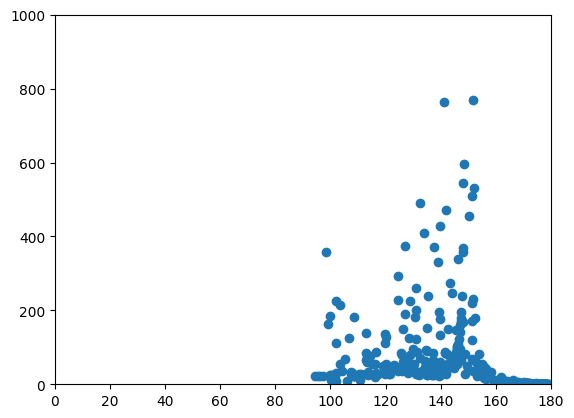

In [77]:
# plot
plt.scatter(x, y)
plt.ylim([0, 1000])
plt.xlim([0, 180])

plt.show()

In [78]:

i,  = np.where(np.isclose(y, np.max(y)))
print(i)

[176]
